# **Don’t Touch Your Face with CNN (Using image_dataset_from_directory)**
## Part 2 Project - Rough Notebook Template
## Jason Graham

---

## 1. Introduction
We collected images for 3 classes:
1. Touch
2. No Hands
3. No Touch w/ Hands

They are stored in a single directory (`MLDL_Data_Face`), each class having multiple subfolders for different subjects. We split off a random sample of 20% of the images for validation automatically using `image_dataset_from_directory`.


## 2. Data Setup & Exploration


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import os

print("TensorFlow version:", tf.__version__)

# hyperparameters
IMG_HEIGHT = 112
IMG_WIDTH = 112
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2  # 20% validation


TensorFlow version: 2.19.0


## 3. Creating Train/Validation Datasets
We used `tf.keras.preprocessing.image_dataset_from_directory` to:
- Recursively load images from each class subfolder
- Automatically split off 20% as validation
- Assign class labels based on the **top-level folder name** (Touch, NoHands, NoTouchHands).


In [24]:
DATA_DIR = "./MLDL_Data_Face"  # Adjust if needed

SEED = 123  # to ensure consistent shuffling/splitting

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 19589 files belonging to 3 classes.
Using 15672 files for training.
Found 19589 files belonging to 3 classes.
Using 3917 files for validation.
Classes: ['NoHands', 'NoTouchHands', 'Touch']


## 4. Optional Data Augmentation
Using the modern Keras approach, we can build an `Sequential` pipeline of random augmentations.


In [27]:
# Example augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# We can apply this to the training dataset using .map()
AUTOTUNE = tf.data.AUTOTUNE

def augment_images(image, label):
    return data_augmentation(image), label

train_ds = train_ds.map(augment_images, num_parallel_calls=AUTOTUNE)

# Also enable prefetching to speed things up
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


## 5. Optional: Visualize a Few Training Images


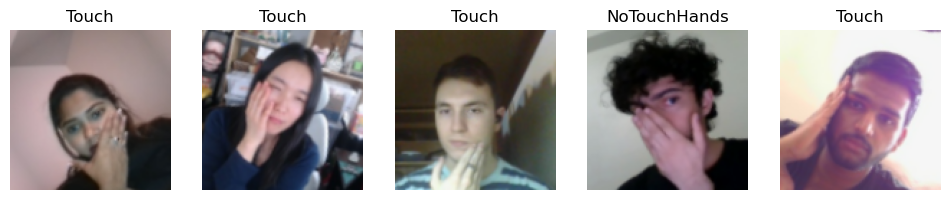

In [30]:
# We'll take one batch from the train_ds
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 12))
    
    # Show up to 5 images (or fewer if the batch is smaller)
    for i in range(min(5, images.shape[0])):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to uint8 image
        # Use the class_names to label the images
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()


## 6. Build CNN Model
Use a CNN or a transfer-learning approach (e.g. MobileNet, VGG, etc.) to classify the 3 classes. 


In [33]:
num_classes = len(class_names)  # Should be 3 for {Touch, NoHands, NoTouchHands}

model = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Normalization(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Normalization(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Normalization(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # note: dataset_from_directory default is int labels
    metrics=['accuracy']
)

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 110, 110, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_3 (Normalization) │ (None, 55, 55, 32)     │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 53, 53, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 51, 51, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_4 (Normalization) │ (None, 25, 25, 64)     │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 23, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_5 (Normalization) │ (None, 11, 11, 128)    │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,113,606 (8.06 MB)

 Trainable params: 2,113,155 (8.06 MB)

 Non-trainable params: 451 (1.77 KB)

## 7. Train the Model
We fit our model on the `train_ds` and validate with `val_ds`.


In [38]:
EPOCHS = 20

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)


Epoch 1/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 125s 251ms/step - accuracy: 0.3884 - loss: 5.9580 - val_accuracy: 0.5583 - val_loss: 0.8995
Epoch 2/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 104s 212ms/step - accuracy: 0.5554 - loss: 0.9011 - val_accuracy: 0.7102 - val_loss: 0.7097
Epoch 3/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 203s 414ms/step - accuracy: 0.6803 - loss: 0.7099 - val_accuracy: 0.8254 - val_loss: 0.4339
Epoch 4/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 124s 254ms/step - accuracy: 0.7431 - loss: 0.5746 - val_accuracy: 0.8614 - val_loss: 0.3590
Epoch 5/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 93s 190ms/step - accuracy: 0.7895 - loss: 0.4800 - val_accuracy: 0.8667 - val_loss: 0.3539
Epoch 6/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 130s 265ms/step - accuracy: 0.8209 - loss: 0.4268 - val_accuracy: 0.8769 - val_loss: 0.3037
Epoch 7/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 119s 242ms/step - accuracy: 0.8282 - loss: 0.4038 - val_accuracy: 0.9076 - val_loss: 0.2325
Epoch 8/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 96s 196ms/step - accuracy: 0.8474 - l

### Plot Accuracy and Loss Curves


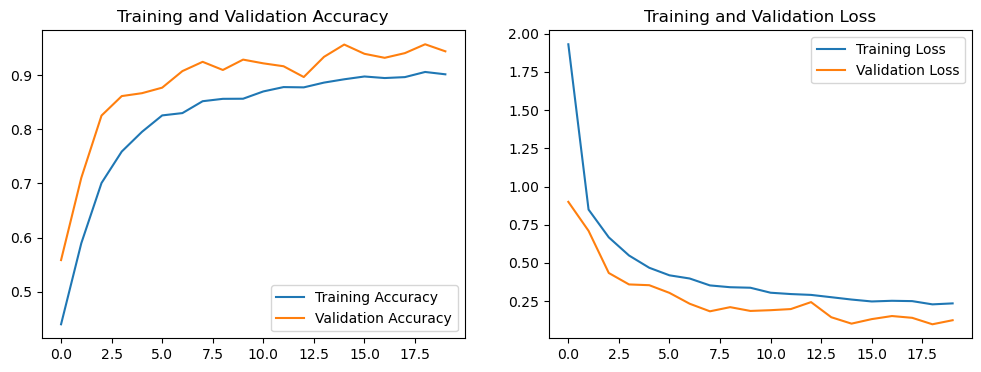

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


## 8. Evaluation & Confusion Matrix
We'll compute predictions on `val_ds`, then build a confusion matrix and classification report.


123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step
Confusion Matrix:
 [[1222    6   15]
 [  15 1180  119]
 [  12   52 1296]]


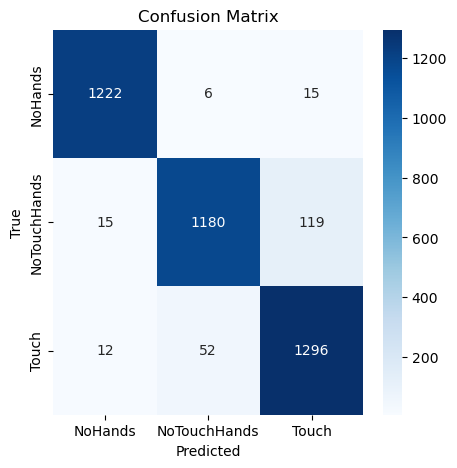

              precision    recall  f1-score   support

     NoHands       0.98      0.98      0.98      1243
NoTouchHands       0.95      0.90      0.92      1314
       Touch       0.91      0.95      0.93      1360

    accuracy                           0.94      3917
   macro avg       0.95      0.94      0.94      3917
weighted avg       0.94      0.94      0.94      3917



In [43]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1) Collect all images & labels from the validation dataset
val_images, val_labels = [], []
for imgs, lbls in val_ds:
    val_images.extend(imgs.numpy())
    val_labels.extend(lbls.numpy())

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# 2) Get predictions
preds = model.predict(val_images)
predicted_class_indices = np.argmax(preds, axis=1)

# 3) Build confusion matrix
cm = confusion_matrix(val_labels, predicted_class_indices)
print("Confusion Matrix:\n", cm)

# 4) Display confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 5) Classification report
report = classification_report(val_labels, predicted_class_indices, target_names=class_names)
print(report)


## 9. Conclusion
Summarize:
- By the conclusion of training the model had achieved over 90% accuracy for the three specified classes in the validation set.
- The confusion matrix looks exactly like what you would expect with each of the three classes being majority correctly assigned
This model had approximately equal parts of each class, allowing for far more successful training than part 1.
